In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gzbuilderspirals import r_theta_from_xy, xy_from_r_theta
import lib.galaxy_utilities as gu
from gzbuilderspirals import fitting

Loading NSA catalog
Loading Zooniverse classification dump
Obtaining available frame montages


In [2]:
with open('./lib/subject-id-list.csv', 'r') as f:
        subjectIds = np.array([int(n) for n in f.read().split('\n')])
        
chosenId = 21097008 #subjectIds[0]
# chosenId = 21686558
gal, angle = gu.get_galaxy_and_angle(chosenId)
pic_array, deprojected_image = gu.get_image(
    gal, chosenId, angle
)

galaxy_object = gu.get_galaxy_spirals(
    gal, angle, chosenId, gu.classifications
)

Working on galaxy 21097008
	- USING MONTAGED IMAGE
	- Getting galaxy rotation
	 Identified 42 arms
	- Clustering arms
	- Fitting arms and errors


/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


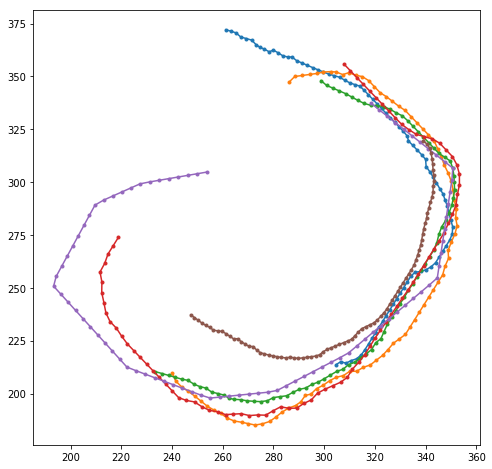

In [3]:
# which arm should we work on?
armN = 0

deprojected_arm = galaxy_object.deproject_arms()[armN]
plt.figure(0, [8]*2); [plt.plot(*arm.T, '.-') for arm in  deprojected_arm.drawn_arms]; None

Text(0.5,0,'Radius from center')

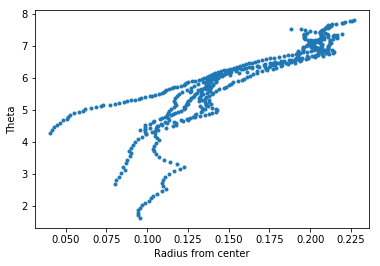

In [4]:
R, t = deprojected_arm.unwrap_and_sort()
a = np.argsort(R)
plt.plot(R, t, '.')
plt.ylabel('Theta')
plt.xlabel('Radius from center')

In [5]:
fitting_result = deprojected_arm.fit()
fitting_result.keys()

dict_keys(['params', 'radial', 'xy_fit', 'pitch_angle', 'clf'])

In [6]:
def recursiveDictExplore(d):
    if type(d) != dict:
        return str(type(d))
    k = d.keys()
    return {i: recursiveDictExplore(d[i]) for i in k}

In [7]:
# __import__('pprint').pprint(recursiveDictExplore(fitting_result))

In [8]:
fitting_result['clf']

{'log_spiral': BayesianRidge(alpha_1=1.0230488753392505e-08, alpha_2=0.6923902410146074,
        compute_score=True, copy_X=True, fit_intercept=True, lambda_1=1e-06,
        lambda_2=1e-06, n_iter=300, normalize=True, tol=0.001,
        verbose=False),
 'polynomial': BayesianRidge(alpha_1=1.0230488753392505e-08, alpha_2=0.6923902410146074,
        compute_score=True, copy_X=True, fit_intercept=True, lambda_1=1e-06,
        lambda_2=1e-06, n_iter=300, normalize=True, tol=0.001,
        verbose=False),
 'polynomial-degree': 4}

(1.116875347401218, 8.309339014127504)

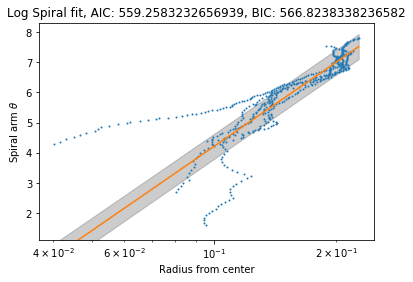

In [9]:
sample_weights = deprojected_arm.get_sample_weight(R)
# plt.plot(R, sample_weights)
log_spiral = fitting.log_spiral_fit(R, t, sample_weight=sample_weights)
plt.plot(R, t, '.', markersize=2)
plt.plot(log_spiral['R'], log_spiral['T'])
plt.fill_between(
    log_spiral['R'],
    log_spiral['T'] - log_spiral['T_std'], 
    log_spiral['T'] + log_spiral['T_std'],
    color='k', alpha=0.2
)
plt.ylabel(r'Spiral arm $\theta$')
plt.xlabel('Radius from center')
plt.xscale('log')
plt.title('Log Spiral fit, AIC: {}, BIC: {}'.format(log_spiral['AIC'], log_spiral['BIC']))
plt.ylim(min(t)-0.5, max(t)+0.5)

In [10]:
polynomials = fitting.get_polynomial_fits(R, t)

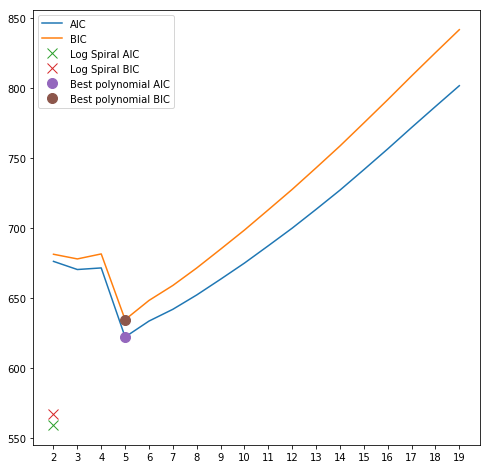

In [11]:
plt.figure(figsize=(8, 8))

plt.plot([i['k'] for i in polynomials], [i['AIC'] for i in polynomials], label='AIC')
plt.plot([i['k'] for i in polynomials], [i['BIC'] for i in polynomials], label='BIC')

plt.plot([2], [log_spiral['AIC']], 'x', markersize=10, label='Log Spiral AIC')
plt.plot([2], [log_spiral['BIC']], 'x', markersize=10, label='Log Spiral BIC')

best_aic = polynomials[np.argmin([i['AIC'] for i in polynomials])]
plt.plot([best_aic['k']], [best_aic['AIC']], 'o', markersize=10, label='Best polynomial AIC')

best_bic = polynomials[np.argmin([i['BIC'] for i in polynomials])]
plt.plot([best_bic['k']], [best_bic['BIC']], 'o', markersize=10, label='Best polynomial BIC')

plt.legend()
_ = plt.xticks([i['k'] for i in polynomials])

In [12]:
logSpiral_xy = xy_from_r_theta(log_spiral['R'], log_spiral['T'])

poly_best_aic_xy = xy_from_r_theta(best_aic['R'], best_aic['T'])
poly_aic_lower_xy = xy_from_r_theta(best_aic['R'], best_aic['T'] - best_aic['T_std'])
poly_aic_upper_xy = xy_from_r_theta(best_aic['R'], best_aic['T'] + best_aic['T_std'])

poly_best_bic_xy = xy_from_r_theta(best_bic['R'], best_bic['T'])
poly_bic_lower_xy = xy_from_r_theta(best_bic['R'], best_bic['T'] - best_bic['T_std'])
poly_bic_upper_xy = xy_from_r_theta(best_bic['R'], best_bic['T'] + best_bic['T_std'])

(-0.13827281953603168,
 0.21094976734679843,
 -0.15673934780262283,
 0.24509454350629772)

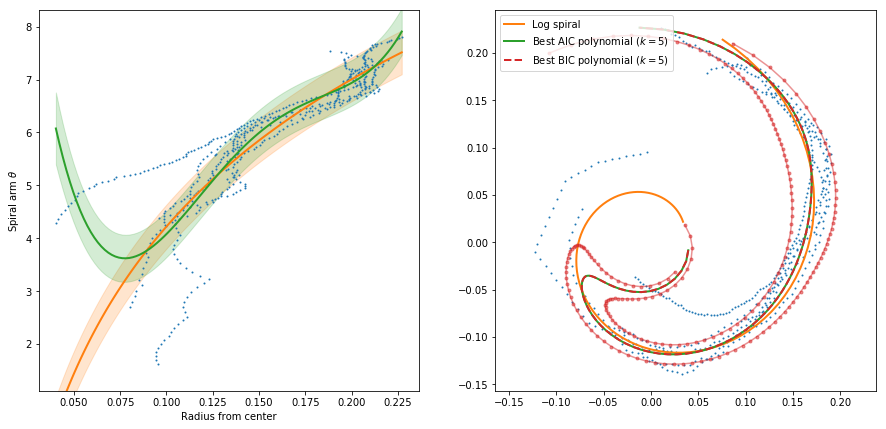

In [13]:
plt.figure(figsize=(15, 7)); plt.subplot(121)
plt.plot(R, t, '.', markersize=2)

# plot the log spiral
plt.plot(log_spiral['R'], log_spiral['T'], linewidth=2)
plt.fill_between(
    log_spiral['R'],
    log_spiral['T'] - log_spiral['T_std'], 
    log_spiral['T'] + log_spiral['T_std'],
    color='C1', alpha=0.2
)

# plot the best polynomial (selected using AIC)
plt.plot(best_aic['R'], best_aic['T'], linewidth=2)
plt.fill_between(
    best_aic['R'],
    best_aic['T'] - best_aic['T_std'], 
    best_aic['T'] + best_aic['T_std'],
    color='C2', alpha=0.2
)
plt.ylim(min(t)-0.5, max(t)+0.5)
plt.ylabel(r'Spiral arm $\theta$')
plt.xlabel('Radius from center')

plt.subplot(122)

plt.plot(*xy_from_r_theta(R, t), '.', markersize=2)
plt.plot(*logSpiral_xy,
         linewidth=2, label='Log spiral')
plt.plot(*poly_best_aic_xy,
         linewidth=2, label='Best AIC polynomial ($k={}$)'.format(best_aic['k']))

plt.plot(*poly_aic_lower_xy, '.-', c='C3', alpha=0.5)
plt.plot(*poly_aic_upper_xy, '.-', c='C3', alpha=0.5)
plt.plot(*poly_best_bic_xy,
         '--', linewidth=2, label='Best BIC polynomial ($k={}$)'.format(best_bic['k']))
plt.legend()
plt.axis('equal')

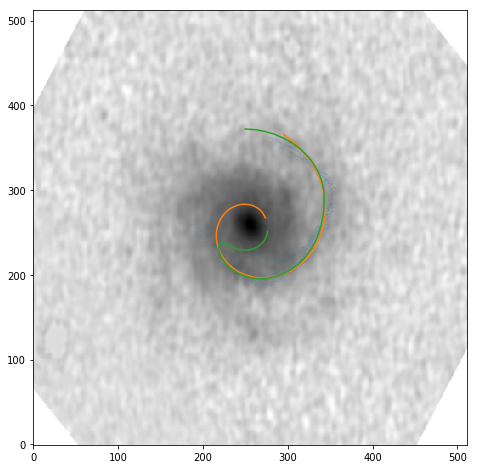

In [14]:
plt.figure(0, [8]*2)
plt.imshow(deprojected_image, cmap='gray_r', origin='lower')
plt.plot(*deprojected_arm.cleaned_cloud.T, '.', markersize=2, alpha=0.1)
plt.plot(*deprojected_arm.de_normalise(np.array(logSpiral_xy)))

plt.plot(*deprojected_arm.de_normalise(np.array(poly_best_aic_xy)))

And there we are, splines, plots and AIC

In [15]:
plt.plot(*deprojected_arm.get_r_bin_weights(deprojected_arm.drawn_arms))

AttributeError: 'GZBArm' object has no attribute 'get_r_bin_weights'

In [16]:
plt.plot(r_bins, z)

NameError: name 'r_bins' is not defined